# News Forensics using K-Means/DBSCAN Clustering and LDA/LSA Topic Modelling using NLP Techniques
## Dataset: 'A Million News Headlines by ABC News'

## Group Members

1.   Muhammad Talal Faiz (365776)
2.   Muhammad Uzair Khan
3.   Umar Tariq

FOR UZAIR: REMEMBER TO MENTION HOW ALL ALGORITHMS MENTIONED IN TITLE WORK IN THE REPORT

FOR UZAIR: DETAILS REGARDING LDA, LSA ,t-SNE. Call me once you are done with most of the report I will add them then. Right now I am tired



# Preparation & Initial Exploratory Data Analysis
## **Context**
The datatset contains a corpus of news headlines posted over a period of almost two decades. Combing through the data the oldest recorded headline is from 19th of February, 2003 and the latest headline is 31st of December 2021. The headlines are all from the same source that is the Australian Broadcasting Corporation abbreviated ABC News. The focus of the dataset is on Australia and as shown below its keywords suggest a good focus on International News for example involving the Iraq War and Elections in the US.
## **Content**
Format: CSV Single File
It has two columns
  1. publish_date: date headline was published in yyyyMMdd format
  2. headline_text: Headline Text in ASCII English Lowercase

### Importing Dataset
Our first step involves importing the dataset using pandas read_csv() function and parsing the date column as dates while automatically inferring the yyyMMdd date format

In [3]:
import pandas as pd
from google.colab import drive
# import os
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/')

df=pd.read_csv('abcnews-date-text.csv',parse_dates=[0],infer_datetime_format=True)
print(df)
df.info()

        publish_date                                      headline_text
0         2003-02-19  aba decides against community broadcasting lic...
1         2003-02-19     act fire witnesses must be aware of defamation
2         2003-02-19     a g calls for infrastructure protection summit
3         2003-02-19           air nz staff in aust strike for pay rise
4         2003-02-19      air nz strike to affect australian travellers
...              ...                                                ...
1244179   2021-12-31  two aged care residents die as state records 2...
1244180   2021-12-31  victoria records 5;919 new cases and seven deaths
1244181   2021-12-31    wa delays adopting new close contact definition
1244182   2021-12-31  western ringtail possums found badly dehydrate...
1244183   2021-12-31  what makes you a close covid contact here are ...

[1244184 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244184 entries, 0 to 1244183
Data columns (total 2 column

### Cleaning Dataset
Now we can start our dataset cleansing. First we will look for any missing entries in our dataset

In [4]:
raw_df=df.copy()
MissingValues=raw_df.isnull()

print(f'Total Number of Missing Values \n{MissingValues.sum()}')

Total Number of Missing Values 
publish_date     0
headline_text    0
dtype: int64


Then we will look for duplicate entries of the same headlines on the same day. Because similar headlines on different days may be relaying different news and can affect the probability of modelling a certain topic

In [5]:

duplicate_df=raw_df.copy()
duplicate_df['cleaned_headline'] = duplicate_df['headline_text'].str.lower().str.strip()
duplicate_df['is_duplicate']=duplicate_df.duplicated(['cleaned_headline','publish_date'],keep=False)
duplicate_df[duplicate_df['is_duplicate']]


,publish_date,headline_text,cleaned_headline,is_duplicate
662094,2011-12-23,the search for sheep price stability,the search for sheep price stability,True
662095,2011-12-23,the search for sheep price stability,the search for sheep price stability,True
1232753,2021-03-01,house prices record sharpest increase since 2003,house prices record sharpest increase since 2003,True
1232754,2021-03-01,house prices record sharpest increase since 2003,house prices record sharpest increase since 2003,True
1237049,2021-06-01,house prices reach record levels; as investors,house prices reach record levels; as investors,True
1237050,2021-06-01,house prices reach record levels; as investors,house prices reach record levels; as investors,True


Now as we can see above our dataset is of a very high quality with only 3 duplicate headlines hence we will now update our raw dataframe as per

In [6]:
cleaned_raw_df=raw_df.copy()
cleaned_raw_df['cleaned_headline'] = cleaned_raw_df['headline_text'].str.lower().str.strip()
cleaned_raw_df=cleaned_raw_df.drop_duplicates(['cleaned_headline','publish_date'],keep='first')
cleaned_raw_df.head()


,publish_date,headline_text,cleaned_headline
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers,air nz strike to affect australian travellers


So we have reduced our total entries from 1244184 to 1244181 successfully removing the 3 duplicates

Next we have to reindex our data so that we can use the published date to identify the headlines rather than the Autonumber assigned by pandas. By doing so it will be helpful to us when we perform our Temporal Analysis

In [7]:
dateindex_df = cleaned_raw_df.copy()
dateindex_df.index = cleaned_raw_df['publish_date']
dateindex_df = dateindex_df.drop(columns=['publish_date'])
dateindex_df.head()

,headline_text,cleaned_headline
publish_date,,
2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation
2003-02-19,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit
2003-02-19,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise
2003-02-19,air nz strike to affect australian travellers,air nz strike to affect australian travellers


Now we are going to explore the actual content of the dataset itself we will start by looking at the recurring prominent keywords across the whole corpus that would allow us to judge what were the main headlines over the past two decades. This will be helpful for us when we get to validate the results of our Topical Modelling

In [8]:
print(len(cleaned_raw_df))


1244181


In [9]:
print(max(cleaned_raw_df.index))

1244183


In [10]:
cleaned_raw_df["index"]=[i for i in range(len(cleaned_raw_df))]
cleaned_raw_df = cleaned_raw_df.set_index('index')
cleaned_raw_df.head()

,publish_date,headline_text,cleaned_headline
index,,,
0,2003-02-19,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers,air nz strike to affect australian travellers


In [11]:
print(len(cleaned_raw_df))


1244181


In [12]:
print(max(cleaned_raw_df.index))

1244180


### Exploring Dataset Content

First thing we will do is take out a randomized sample from our dataset to reduce the amount of entries we process because of our limited computing resource.

To do that we need to see the distribution of our dataset over time

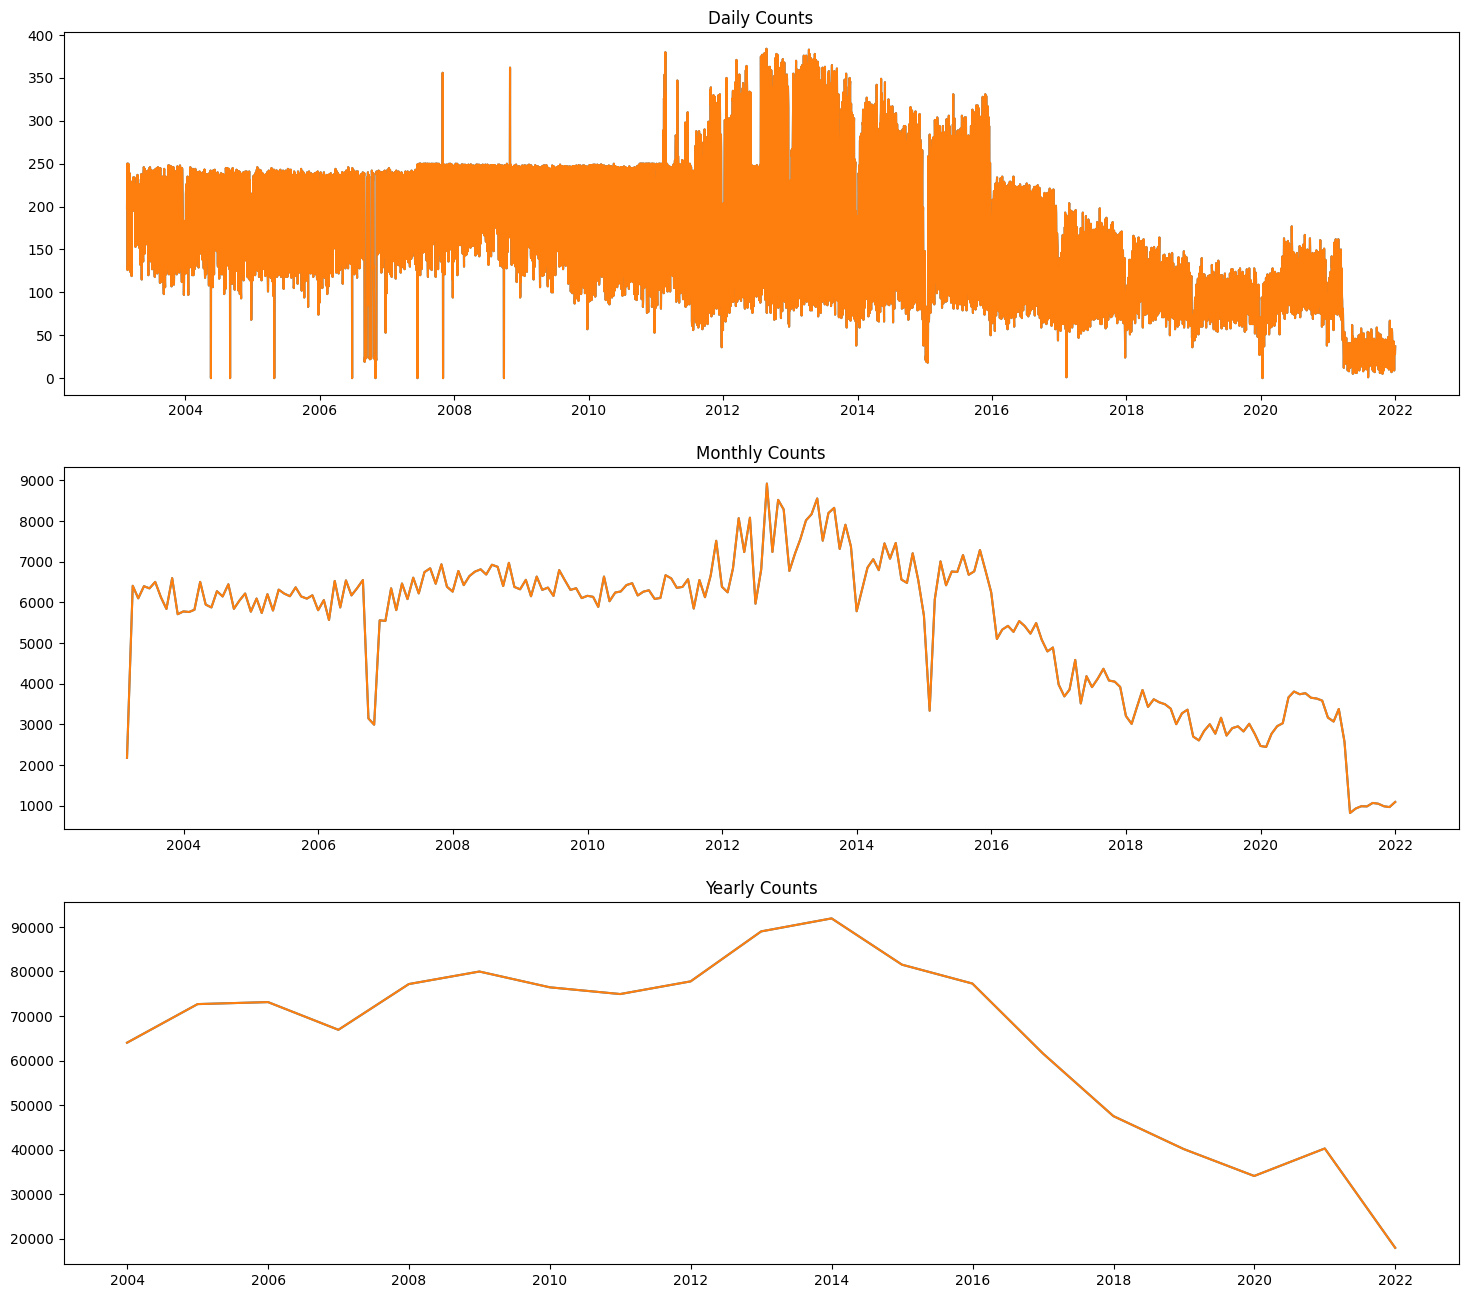

In [13]:
import matplotlib.pyplot as plt
monthly_counts = dateindex_df.resample('M').count()
yearly_counts = dateindex_df.resample('A').count()
daily_counts = dateindex_df.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

In [14]:
print(yearly_counts)


              headline_text  cleaned_headline
publish_date                                 
2003-12-31            63997             63997
2004-12-31            72674             72674
2005-12-31            73124             73124
2006-12-31            66901             66901
2007-12-31            77174             77174
2008-12-31            79991             79991
2009-12-31            76444             76444
2010-12-31            74931             74931
2011-12-31            77777             77777
2012-12-31            89008             89008
2013-12-31            91928             91928
2014-12-31            81531             81531
2015-12-31            77290             77290
2016-12-31            61574             61574
2017-12-31            47511             47511
2018-12-31            40102             40102
2019-12-31            34060             34060
2020-12-31            40240             40240
2021-12-31            17924             17924


In [15]:
sample_size = 100000


def stratified_sample_size(data, column, size):
    weights = data[column] / data[column].sum()
    sample_sizes = (weights * size).astype(int)
    return sample_sizes


yearly_sample = stratified_sample_size(yearly_counts, 'cleaned_headline', size=sample_size)
yearly_sample.index = pd.to_datetime(yearly_sample.index)

monthly_samples = []

for year in yearly_sample.index:
    year_data = dateindex_df.loc[year.strftime('%Y')]
    monthly_sample_size = stratified_sample_size(year_data.resample('M').count(), 'cleaned_headline', size=yearly_sample[year])
    monthly_samples.append(monthly_sample_size)



final_monthly_sample_size = pd.concat(monthly_samples)


daily_samples = []

for month in final_monthly_sample_size.index:
    month_data = dateindex_df.loc[month.strftime('%Y-%m')]
    daily_sample_size = stratified_sample_size(month_data.resample('D').count(), 'cleaned_headline', size=final_monthly_sample_size[month])
    daily_samples.append(daily_sample_size)


final_daily_sample_size = pd.concat(daily_samples)




In [16]:
final_dataset=[]
for day in final_daily_sample_size.index:
  if (final_daily_sample_size[day]!=0):
    day_data=dateindex_df.loc[day.strftime("%Y-%m-%d")].sample(final_daily_sample_size[day])
    final_dataset.append(day_data)

final_dataset_df = pd.concat(final_dataset)
final_dataset_df.head()

,headline_text,cleaned_headline
publish_date,,
2003-02-19,search continues for victims in south korean s...,search continues for victims in south korean s...
2003-02-19,blizzard buries united states in bills,blizzard buries united states in bills
2003-02-19,investigations underway into death toll of korean,investigations underway into death toll of korean
2003-02-19,meeting to focus on broken hill water woes,meeting to focus on broken hill water woes
2003-02-19,smoking bans hit tabcorp bottom line,smoking bans hit tabcorp bottom line


In [17]:
final_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96308 entries, 2003-02-19 to 2021-12-31
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   headline_text     96308 non-null  object
 1   cleaned_headline  96308 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [18]:
all_headlines=final_dataset_df['headline_text']
all_headlines.reset_index(drop=True)
all_headlines.head()
# df_reset.drop(['publish_date'],axis=1)

all_headlines.to_csv('all_headlines.txt', index=False)

Next we take a look at the distribution of our final dataset

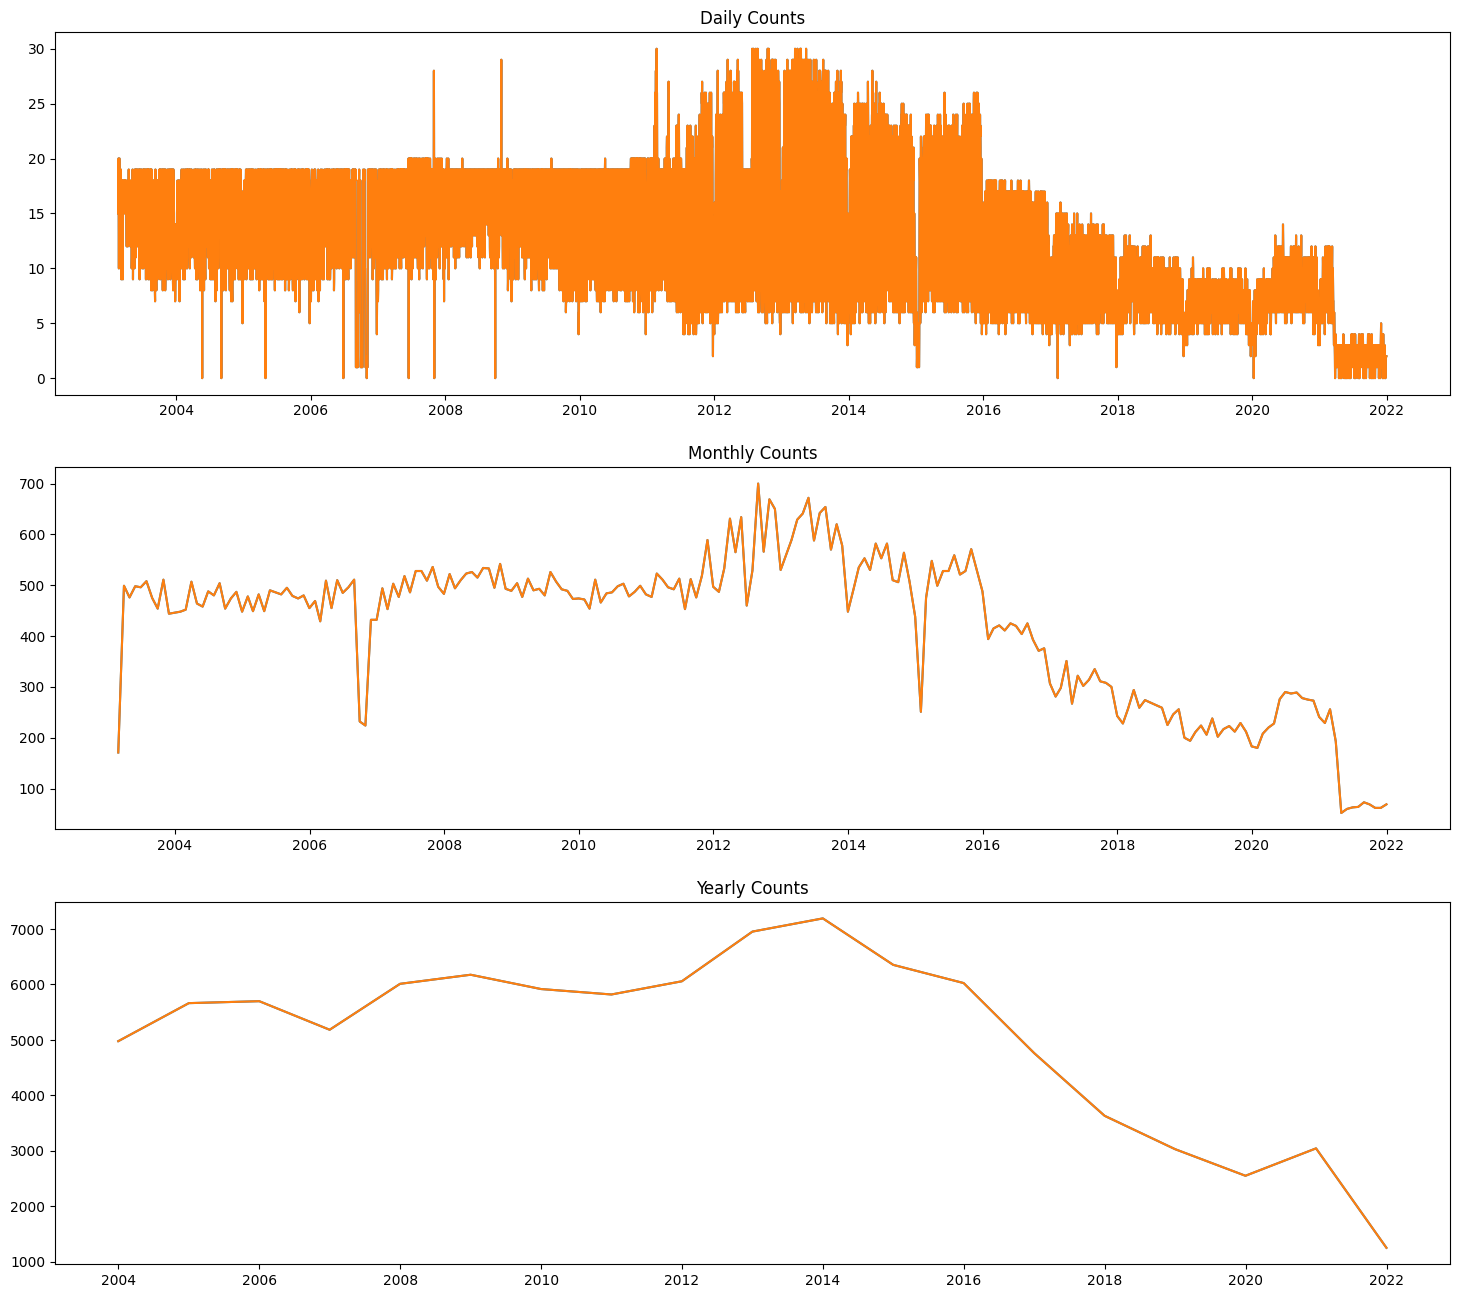

In [18]:
monthly_counts = final_dataset_df.resample('M').count()
yearly_counts = final_dataset_df.resample('A').count()
daily_counts = final_dataset_df.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

For this task we are going to use CountVectorizer a feature extraction tool that cleans our corpus's individual headlines and then identifies the Unique Words in the entire corpus it will then return us a Sparse Matrix with entries of the counts of each unique word across each Headline in our corpus. Moreover it also will filter out the stop words we use in english such as 'a' 'the' 'at'. These are of no interest to us and contribute no information in analysing our corpus as well as punctuations.

Note: Our matrix will be sparse because many Unique Words may not occur more than once across the entire corpus.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

**But apart from using the CountVectorizer we have to also use a stemmer to find the root words throughout all headlines. For example: Jobs root word is Job this will help us reduce our feature space when we go on to apply some of our algorithms and also it makes sure our model only deals with core word meanings of the headlines not every plural or singular form**

In [1]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
nltk.download('stopwords')
snowball_stemmer = SnowballStemmer("english")
stop_words_nltk = set(stopwords.words('english'))
stop_words_custom = list(stop_words_nltk.union(set(string.punctuation)))
Vectorizer = TfidfVectorizer(stop_words=stop_words_custom)
Headlines=final_dataset_df['cleaned_headline'].values
Stemmed_Headlines = [" ".join([snowball_stemmer.stem(word) for word in Headline.split()]) for Headline in Headlines]

Vectorized_Headlines=Vectorizer.fit_transform(Headlines)
Vocabulary=Vectorizer.get_feature_names_out()
Word_Counts=Vectorized_Headlines.sum(axis=0)

def stem_headline(Headline):
    return " ".join([snowball_stemmer.stem(word) for word in Headline.split()])
dateindex_df['stemmed_headline'] = dateindex_df['cleaned_headline'].apply(stem_headline)
dateindex_df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


NameError: ignored

As seen above we used a combination of the fit and transform functions. Fit to analyse our corpus and 'learn' all the unique vocabulary and transform to convert each headline in our corpus to a vector with values that represent the counts of any of the words in the vocabulary

**Note: 'Learn' here doesn't mean learning as in ML**

So we have performed our initial cleaning and exploring of the content of our data but now we need to know the density or sparsity of our data samples with respect to certain features. One of the features used for finding our sample density will be tagged part-of-speech (further explained below) and the length of our headlines. Inaddition we will also be checking our sample density with respect to time (Weekly, Monthly, Yearly). This will be useful when we conduct our topical analysis over time later on. We will also be looking at Frequent Words to validate our topical modelling results

First we are going to look at the overall most occurring words so that when we can validate our findings from when we perform our Topical Modelling using LSA or LDA and perform comparisons between them.

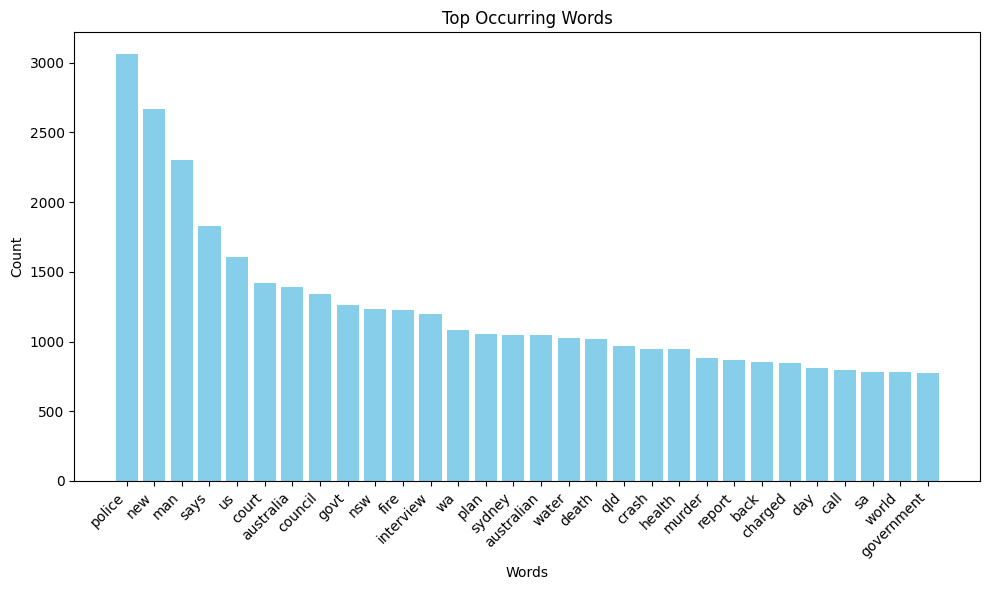

In [21]:
import matplotlib.pyplot as plt
top_words_df=pd.DataFrame({'Word':Vocabulary,'Count':Word_Counts.flat})
top_words_df = top_words_df.sort_values(by='Count', ascending=False)
top_words_df = top_words_df.head(30)
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top Occurring Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Next lets take a look at the sample density with time

The overall trend our dataset shows that the major amount of samples are from 2012-2016 and before that from 2004-2011 it has a constant amount of samples albeit lower counts with respect to each day, month and year and finally we have a decreasing amount of counts from 2017-2020 with a small spike in 2020-2021 because of COVID and the final decline in counts towards the end since we dont have headlines from 2022

Then we will look at Part-Of-Speech taggings with respect to the entire corpus so that we can check for any errors that may have occured during our tokenization, visualise the overall style of our headlines and we will also be able to use it for enhancing the LDA/LSA results respectively by filtering our dataset so that only the most meaningful parts of speech i.e: Nouns and Verbs are included in our final Sparse Matrix

In [22]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from textblob import TextBlob
tagged_words = [TextBlob(word).tags for word in Vocabulary]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The foremost thing we do is convert each one of our headlines into a Text Blob object. Textblob is one of the best libraries used to perform text analysis or NLP tasks suchas P-O-S, Classification, Sentiment Analysis etc. It is easy to use and beginner friendly hence our choice. It is built ontop of the NLTK and a text blob object can call methods to analyse text such as in our case the P-O-S tagging.


[[('00', 'CD')], [('000', 'CD')], [('006', 'CD')], [('007', 'CD')], [('01', 'CD')], [('0101', 'CD')], [('010715', 'CD')], [('0108', 'CD')], [('0112', 'CD')], [('018', 'CD')], [('01am', 'CD')], [('02', 'CD')], [('0206', 'CD')], [('0207', 'CD')], [('0209', 'CD')], [('0210', 'CD')], [('0211', 'CD')], [('0212', 'CD')], [('03', 'CD')], [('0302', 'CD')], [('0304', 'CD')], [('030715', 'CD')], [('0311', 'CD')], [('04', 'CD')], [('0406', 'CD')], [('0422', 'CD')], [('05', 'CD')], [('0503', 'CD')], [('0505', 'CD')], [('0506', 'CD')], [('0508', 'CD')], [('0509', 'CD')], [('06', 'CD')], [('0603', 'CD')], [('0611', 'CD')], [('0612', 'CD')], [('0658', 'CD')], [('07', 'CD')], [('0702', 'CD')], [('0703', 'CD')], [('0705', 'CD')], [('0708', 'CD')], [('070915', 'CD')], [('08', 'CD')], [('0805', 'CD')], [('0808', 'CD')], [('09', 'CD')], [('0906', 'CD')], [('090615', 'CD')], [('0910', 'CD')], [('095', 'CD')], [('10', 'CD')], [('100', 'CD')], [('1000', 'CD')], [('10000', 'CD')], [('100000', 'CD')], [('1000m

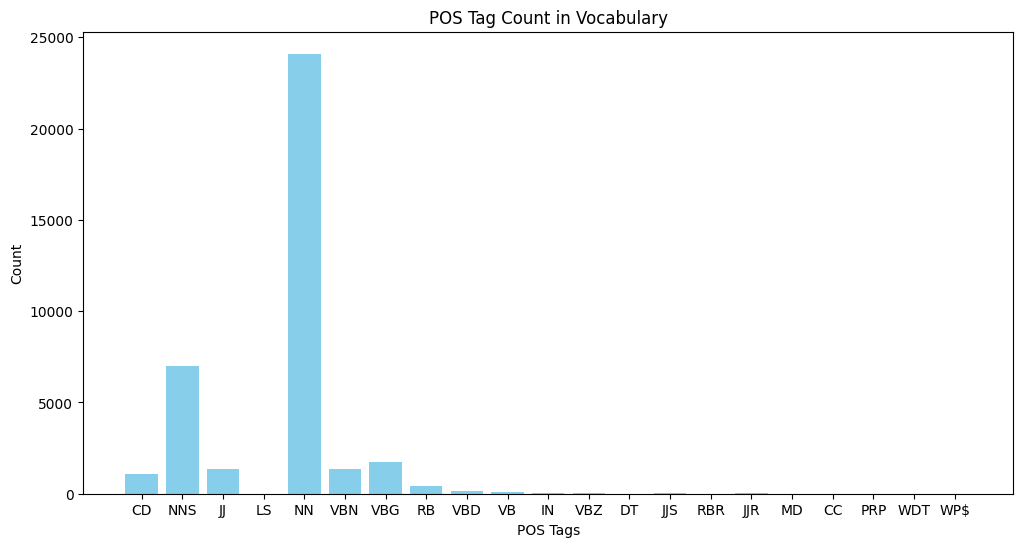

In [23]:
from collections import Counter
print(tagged_words)
all_tags = [tag for tags in tagged_words for _, tag in tags]
tag_counts = Counter(all_tags)

plt.figure(figsize=(12, 6))
plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue')
plt.xlabel('POS Tags')
plt.ylabel('Count')
plt.title('POS Tag Count in Vocabulary')
plt.show()

Our findings above show that we have the following prominent categories in our dataset:
1. NN: Nouns Singular
2. NNS: Nouns Plural
3. VBG: Verbs present participle
4. VBN: VERBS
5. VBD: VERBS
6. RB: Adverbs
7. CD: Cardinal Numbers
8. JJ: Adjectives

In our topic modelling the most useful categories will be NN, NNS, All Verbs

In [24]:
import numpy as np
from scipy.sparse import csr_matrix
def filter_nouns_and_verbs(tags):
    filtered_words = [word for word, tag in tags if tag.startswith('N') or tag.startswith('V')]
    return filtered_words if filtered_words else None

filtered_words = [filter_nouns_and_verbs(tags)[0] for tags in tagged_words if filter_nouns_and_verbs(tags)]
print(filtered_words)

filtered_words_set = set(filtered_words)
filtered_indices = [i for i, word in enumerate(Vocabulary) if word in filtered_words_set]
filtered_vocabulary=[word for word in Vocabulary if word in filtered_words_set]

filtered_sparse_matrix = Vectorized_Headlines[:, filtered_indices]
POSFilteredHeadlines=filtered_sparse_matrix

top_words_df = pd.DataFrame({'Word': Vocabulary[filtered_indices], 'Count': filtered_sparse_matrix.sum(axis=0).flat})


['100th', '10th', '120th', '150th', '15th', '170th', '175th', '17th', '18th', '1950s', '1960s', '1970s', '36ers', '49ers', '5th', '60s', '700th', '70s', '70th', '75th', '76ers', '7th', 'a1', 'a1s', 'a2', 'a380', 'aa', 'aa1', 'aaa', 'aaco', 'aad', 'aamer', 'aamodt', 'aant', 'aargau', 'aaron', 'ab', 'aba', 'abaaoud', 'abalone', 'abama', 'abandon', 'abandoned', 'abandoning', 'abandons', 'abare', 'abares', 'abattoi', 'abattoir', 'abattoirs', 'abb', 'abba', 'abbas', 'abbatoirs', 'abbattoir', 'abbey', 'abboott', 'abbot', 'abbotsbury', 'abbotsford', 'abbott', 'abbotts', 'abc', 'abcc', 'abcs', 'abdallah', 'abdel', 'abdelhamid', 'abdication', 'abdomen', 'abduct', 'abducted', 'abducting', 'abduction', 'abductions', 'abductor', 'abdul', 'abdullah', 'abe', 'abercrombie', 'aberdeen', 'abermain', 'abernethy', 'aberration', 'abes', 'abestos', 'abetz', 'abf', 'abflex', 'abgc', 'abhilash', 'abhorrent', 'abiding', 'abilities', 'ability', 'abjorensen', 'abkhazia', 'abl', 'ablaze', 'ableton', 'ablett', 'a

In [ ]:
with open('filtered_vocabulary.pkl', 'wb') as file:
    pickle.dump(filtered_vocabulary, file)

Now lets have a final look at our topmost occuring words

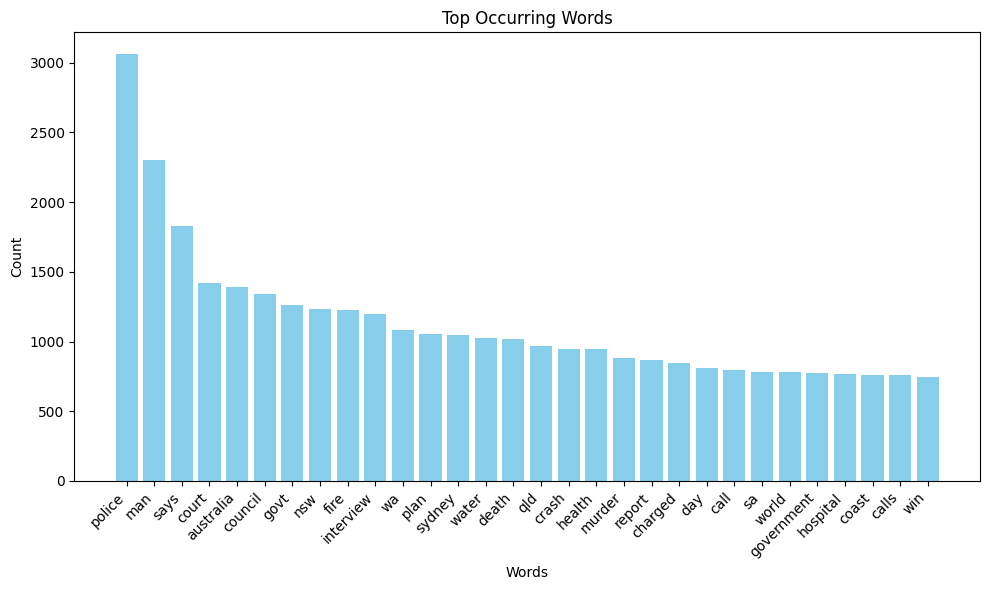

In [25]:

top_words_df = top_words_df.sort_values(by='Count', ascending=False)
top_words_df = top_words_df.head(30)
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['Word'], top_words_df['Count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top Occurring Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Finally we will look at the average headline length to identify any outliers

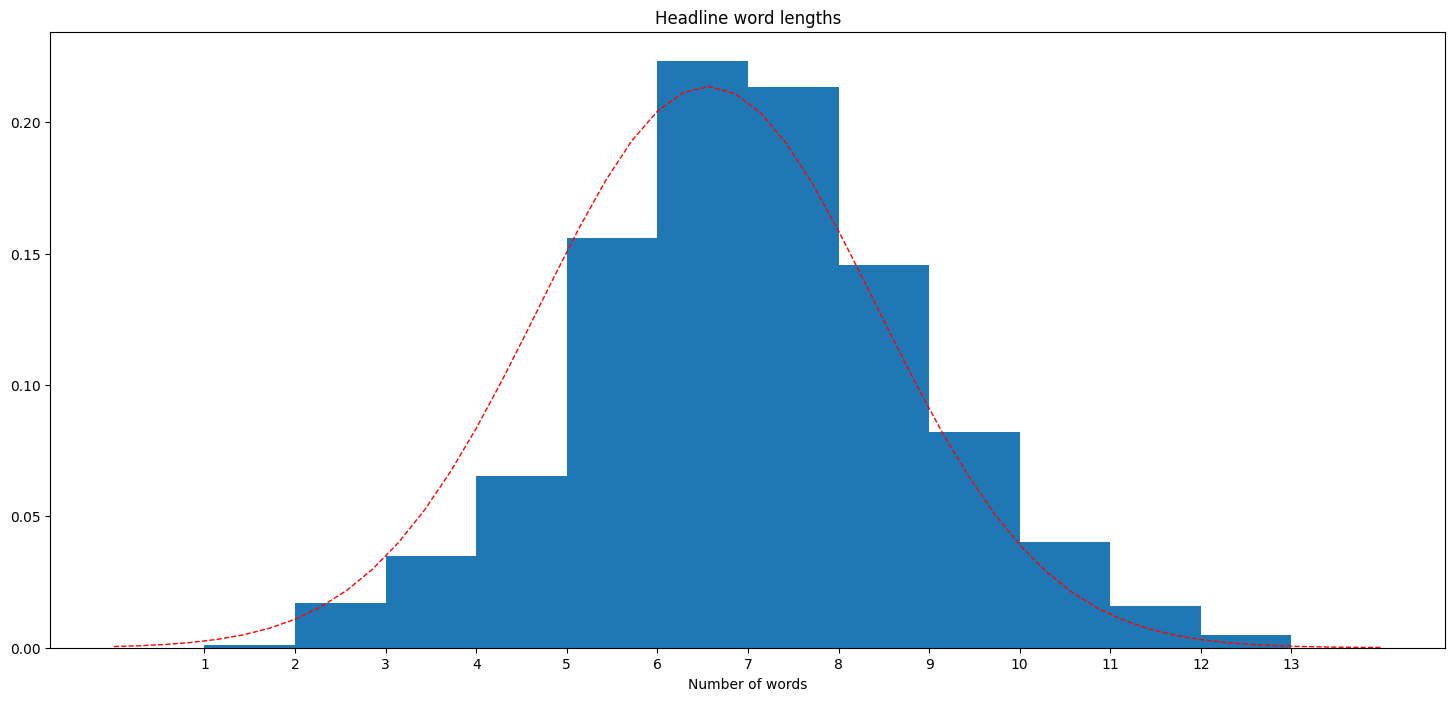

Total number of words:  631750
Mean number of words per headline:  6.55968351538813


In [26]:
import scipy.stats as stats
word_counts = []
for headline in Headlines:
    word_counts.append(len(headline.split()))
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Finally we have done all our Exploratory Data Analysis. We have prepared our dataset accordingly and made changes where necessary now we can move onto the next step which is the actual training of our model and evaluation of it's results

# Applying DBSCAN to find Optimal Clusters

In [27]:
from sklearn.cluster import DBSCAN

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(POSFilteredHeadlines)

Hyperparameter Tuning for DBSCAN

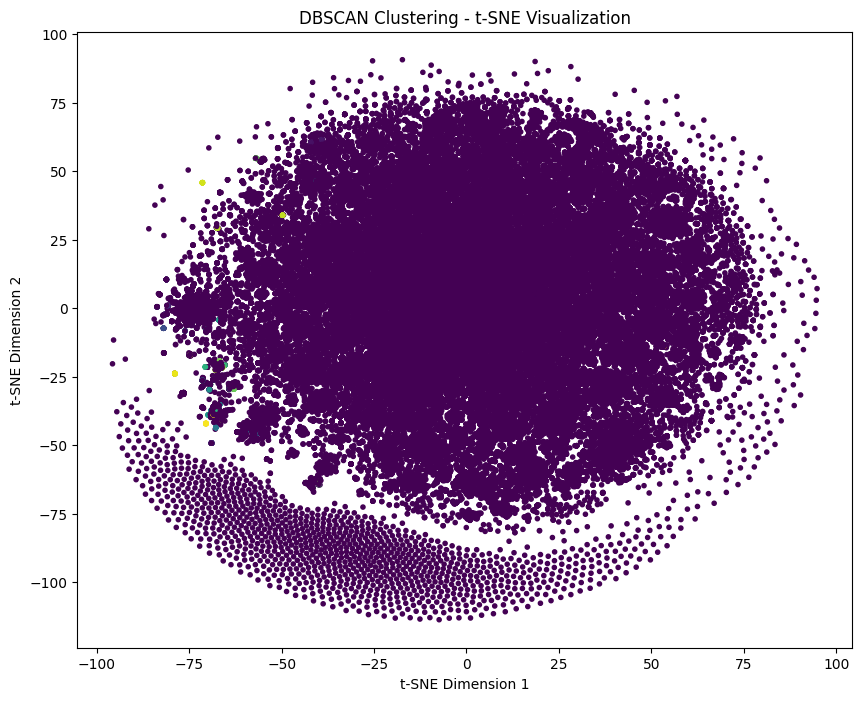

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42,init='random')
X_tsne = tsne.fit_transform(POSFilteredHeadlines)

# Plotting the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_clusters, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering - t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [28]:

num_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)



print(f"Number of clusters: {num_clusters}")

Number of clusters: 101


In [ ]:
import numpy as np
unique_labels, counts = np.unique(dbscan_clusters, return_counts=True)
print("Cluster sizes:", dict(zip(unique_labels, counts)))


NameError: ignored

# Topical Modelling
## **GOAL**

The core of our project involves using the results of Topical Modelling as a basis to perform analyses on our headlines dataset to extract conclusions on what happened in the past 2 decades but this all must be done on subsets of data that contain the different topics that were the themes of our past two decades, and prior to all of this we need to find the topical modelling algorithm that gives us the best results and the two contenders we have now are:
1. Latent Dirchelt Allocation (LDA)
2. Latent Semantic Analysis (LSA)

## **METRICS**

Visualise and Compare results using Cluster Plots, Word Clouds etc. then go on to perform analysis over the results like heatmap, geomaps etc.

## **PROBLEMS**

**However moving further we have a very simple problem. Choosing between pre-process clustering or post-process clustering. There are multiple reasonings for this.**

Reasons for Pre-processing:
1. Targeted Analysis of specific clusters related to specific event can be done using the clusters already made beforehand
2. More specific and coherent topics are returned if we do topical modelling after clustering
3. Choose different parameters for the topical modelling algorithm we use for each clustering making sure it is the most suitable for that cluster

Reasons for Post-Processing:
1. Gain the Global Context as there maybe topics/themes that could span multiple clusters
2. Gain a comprehensive understanding and maybe uncover some unexpected trend
3. The entire nature of our dataset is not known before hand. Our EDA suggests that we have all sorts of news it is a mixture of topics hencue using post-processing we will have an Unsupervised discovery of each topic whereas in Pre-Processing we will lose this aspect as we will supervise and limit our working clusters

Furthermore we have to decide between DBSCAN and K-Means as our pre/post processing clustering algorithms

And at the end we will create a function which will take as input a recent headline and predict it's topical group as well as other related headlines from past

## Experimental Workflow






###   1. Experimenting with LSA & LDA
    


#### LDA
As shown below we are going to be applying LDA to a small subset of our dataset to find out how well it is working out. To that end we will look at the recognised topics and then we will also plot each topic with respect to its no of headlines using t-SNE (t-distributed Stochastic Neighbour Embedding). It will cause dimensionality reduction allowing us to plot of our results on scatterplot

The result of lda is a document-topic matrix what it does is take the document-term matrix and change it so that each row is a document/headline and each column is a topic and the entries are the probabilities that one of those topics is dominant in the headlines.

Next we will visualise what each one of the topics are and what are their respective headline counts from initial subset of the entire dataset we looked at

Our second visualisation will show how well distinct our topics are and how well the clusters are separated

Finally the desired heatmap for the each topic over the years is made by using the random fraction of the entire data and running LDA on it


Combining it all we can create an Interactive Widget that changes the num of topics and training set size and visualise the respective results

In [29]:
!pip install tmtoolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=cf8c1b78eab934ccf1027fb71f30de47881f5668b96548d0a3a3efb9a2c05097
  Stored in directory: /root/.cache/pip/wheels/e6/c5/26/0d27e07d567b3b4e63a618efff19a2cdbab636ac1295d20206
Successfully built globre


Topic 1: coronavirus, darwin, covid, strike, john, put, cases, bali, records, causes
Topic 2: funds, rally, dairy, reveals, welcome, transport, groups, gay, firm, thursday
Topic 3: students, days, bashing, tourist, issue, brings, apology, threatened, protest, rice
Topic 4: death, woman, attack, baby, prompts, pair, london, theft, police, easter
Topic 5: school, pacific, named, signs, terrorism, see, come, outbreak, die, right
Topic 6: violence, greens, club, policy, need, spot, reform, press, scare, overhaul
Topic 7: news, business, emergency, speaks, blues, abc, liberals, sea, eagles, analysis
Topic 8: trade, league, issues, impact, focus, training, shortage, tipped, vaccine, problem
Topic 9: afl, reports, round, fans, agreement, approves, paris, celebrate, evacuated, tight
Topic 10: child, sex, charges, abuse, church, apologises, mobile, heads, porn, dropped
Topic 11: debate, shire, play, leaders, president, sets, role, remain, heart, pole
Topic 12: care, commission, royal, youth, ag

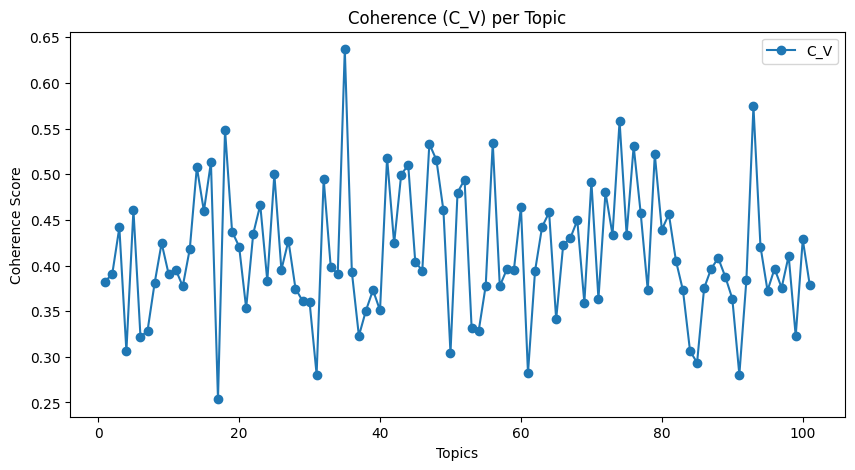

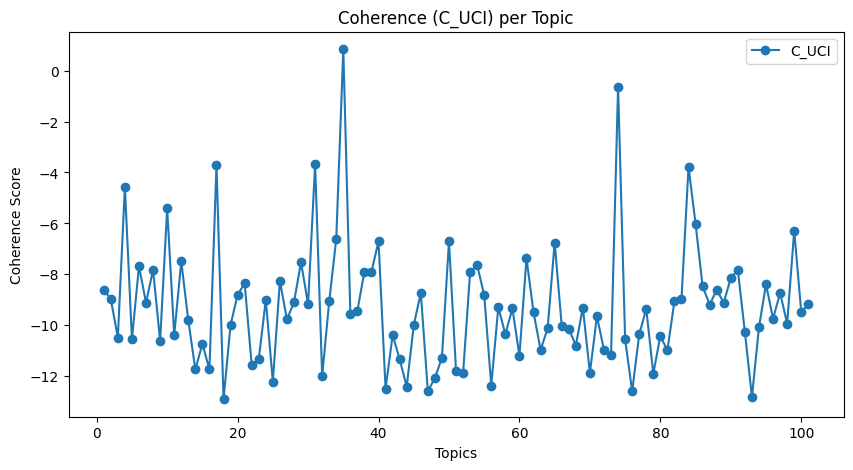

In [56]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import gensim
import matplotlib.pyplot as plt
import numpy as np


num_topics_lda = 101


lda_model = LatentDirichletAllocation(n_components=num_topics_lda, random_state=42)

def visualize_lda(num_words_per_topic):
    global lda_topic_words
    global lda_result


    lda_result = lda_model.fit_transform(filtered_sparse_matrix)

    feature_names = filtered_vocabulary

    lda_topic_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_word_indices = np.argsort(topic)[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]
        lda_topic_words.append(top_words)
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

    vocab = np.array(filtered_vocabulary)


    lda_coherence_c_v = CoherenceModel(
        topics=lda_topic_words,
        texts=[headline.split() for headline in Headlines],
        dictionary=gensim.corpora.Dictionary([headline.split() for headline in Headlines]),
        coherence='c_v'
    )
    print(f"Coherence (C_V) for Topics: {lda_coherence_c_v.get_coherence()}")
    print(f"Average Coherence score (C_V): {lda_coherence_c_v.get_coherence()}")


    lda_coherence_c_uci = CoherenceModel(
        topics=lda_topic_words,
        texts=[headline.split() for headline in Headlines],
        dictionary=gensim.corpora.Dictionary([headline.split() for headline in Headlines]),
        coherence='c_uci'
    )
    print(f"Coherence (C_UCI) for Topics: {lda_coherence_c_uci.get_coherence()}")
    print(f"Average Coherence score (C_UCI): {lda_coherence_c_uci.get_coherence()}")


    topics = list(range(1, num_topics_lda + 1))


    plt.figure(figsize=(10, 5))
    plt.plot(topics, lda_coherence_c_v.get_coherence_per_topic(), marker='o', label='C_V')
    plt.xlabel('Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence (C_V) per Topic')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(topics, lda_coherence_c_uci.get_coherence_per_topic(), marker='o', label='C_UCI')
    plt.xlabel('Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence (C_UCI) per Topic')
    plt.legend()
    plt.show()


visualize_lda(num_words_per_topic=10)


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: ignored

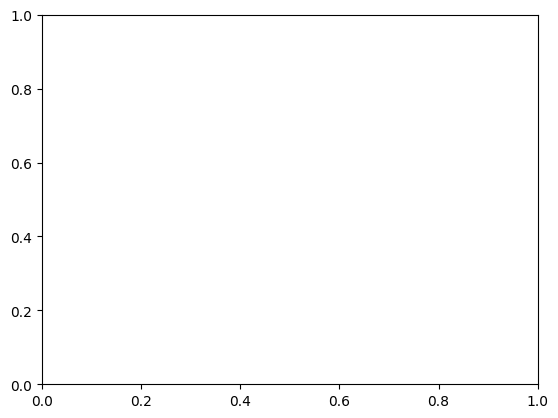

In [42]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import matplotlib.pyplot as plt
import numpy as np


num_topics_values = [20, 40, 60,80,100,105,110,115,120]


coherence_scores = []


for num_topics in num_topics_values:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_result = lda_model.fit_transform(filtered_sparse_matrix)


    coherence_c_v = metric_coherence_gensim(
        measure='c_v',
        topic_word_distrib=lda_model.components_,
        dtm=filtered_sparse_matrix,
        vocab=np.array(filtered_vocabulary),
        texts=[headline.split() for headline in Headlines]
    )

    coherence_scores.append({'num_topics': num_topics, 'coherence_c_v': coherence_c_v})


num_topics_values = [entry['num_topics'] for entry in coherence_scores]
coherence_c_v_values = [entry['coherence_c_v'] for entry in coherence_scores]




[0.41473914525929007, 0.5106435470660763, 0.5652356206051116, 0.5835404866451203, 0.5980100728297982, 0.30199809306440545]


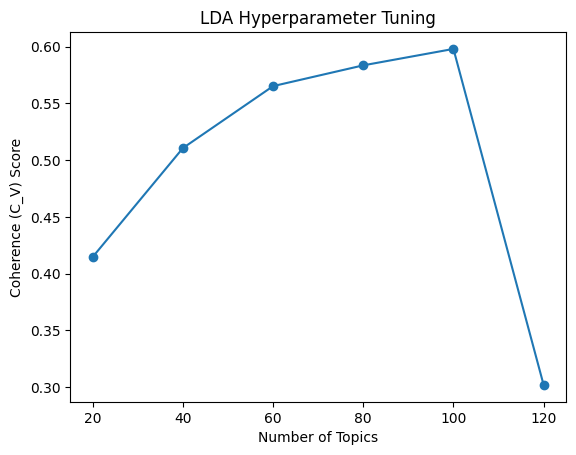

In [54]:
print(coherence_c_v_values)
for i in range(len(coherence_c_v_values)):
  coherence_c_v_values[i]=np.mean(coherence_c_v_values[i])

plt.plot(num_topics_values, coherence_c_v_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence (C_V) Score')
plt.title('LDA Hyperparameter Tuning')
plt.show()

[0.41473914525929007, 0.5106435470660763, 0.5652356206051116, 0.5835404866451203, 0.5980100728297982, 0.30199809306440545]


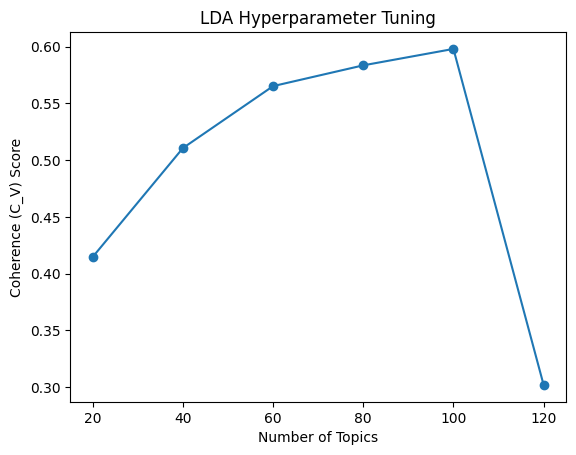

In [53]:
print(coherence_c_v_values)
for i in range(len(coherence_c_v_values)):
  coherence_c_v_values[i]=np.mean(coherence_c_v_values[i])

plt.plot(num_topics_values, coherence_c_v_values, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence (C_V) Score')
plt.title('LDA Hyperparameter Tuning')
plt.show()


In [ ]:
import pickle

with open('lda_model.pk', 'wb') as file:
    pickle.dump(lda_result, file)

In [ ]:
with open('lda_model.pk' , 'rb') as f:
    lr = pickle.load(f)

##GENSIM VERSION LDA

In [39]:
import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

nltk.download('stopwords')


def preprocess_text(text):

    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()


    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return tokens


processed_headlines = [preprocess_text(headline) for headline in Headlines]


dictionary = corpora.Dictionary(processed_headlines)


corpus = [dictionary.doc2bow(headline) for headline in processed_headlines]


num_topics_lda = 101


lda_model = LdaModel(corpus, num_topics=num_topics_lda, id2word=dictionary, passes=15, random_state=42)


for topic_idx, topic in lda_model.print_topics():
    print(f"Topic {topic_idx + 1}: {topic}")


coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_headlines, dictionary=dictionary, coherence='c_v')

lda_coherence_c_uci = CoherenceModel(
        model=lda_model,
        texts=processed_headlines,
        dictionary=dictionary,
        coherence='c_uci'
    )
print(f"Coherence (C_UCI) for Topics: {lda_coherence_c_uci.get_coherence()}")
# print(f"Average Coherence score (C_UCI): {lda_coherence_c_uci.get_coherence()}")


lda_coherence_c_umass = CoherenceModel(
    model=lda_model,
    texts=processed_headlines,
    dictionary=dictionary,
    coherence='c_umass'
)
print(f"Coherence (C_UMASS) for Topics: {lda_coherence_c_umass.get_coherence()}")
# print(f"Average Coherence score (C_UMASS): {lda_coherence_c_umass.get_coherence()}")
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 38: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*"townie" + 0.000*"kenwick" + 0.000*"priors"
Topic 72: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*"townie" + 0.000*"kenwick" + 0.000*"priors"
Topic 39: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*"townie" + 0.000*"kenwick" + 0.000*"priors"
Topic 41: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*"townie" + 0.000*"kenwick" + 0.000*"priors"
Topic 49: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*"townie" + 0.000*"kenwick" + 0.000*"priors"
Topic 73: 0.000*"wba" + 0.000*"insanity" + 0.000*"vidot" + 0.000*"doelz" + 0.000*"jayson" + 0.000*"whish" + 0.000*"cotto" + 0.000*

KeyError: ignored

# Implementing NMF

In [ ]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import seaborn as sns
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


num_topics_nmf = 101


nmf_model = NMF(n_components=num_topics_nmf, random_state=42)
print(nmf_model)

def visualize_nmf(num_words_per_topic):
    global nmf_topic_words
    global nmf_result


    nmf_result = nmf_model.fit_transform(filtered_sparse_matrix)

    feature_names = filtered_vocabulary

    nmf_topic_words = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_word_indices = np.argsort(topic)[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]
        nmf_topic_words = top_words
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

    vocab = np.array(filtered_vocabulary)
    nmf_coherence_c_v = metric_coherence_gensim(
        measure='c_v',
        topic_word_distrib=nmf_model.components_,
        dtm=filtered_sparse_matrix,
        vocab=vocab,
        texts=[headline.split() for headline in Headlines]
    )
    print(f"Coherence (C_V) for Topics: {nmf_coherence_c_v}")
    print(f"Average Coherence score: {sum(nmf_coherence_c_v) / len(nmf_coherence_c_v)}")


visualize_nmf(num_words_per_topic=10)


NMF(n_components=101, random_state=42)


NameError: ignored

# Gensim NMF

In [ ]:
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel


num_topics_nmf = 101


nmf_model = NMF(n_components=num_topics_nmf, random_state=42)

def visualize_nmf(num_words_per_topic):
    global nmf_topic_words
    global nmf_result


    nmf_result = nmf_model.fit_transform(filtered_sparse_matrix)

    feature_names = filtered_vocabulary

    nmf_topic_words = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_word_indices = np.argsort(topic)[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]
        nmf_topic_words = top_words
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


    id2word = Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))
    corpus_nmf = gensim.matutils.Sparse2Corpus(filtered_sparse_matrix, documents_columns=False)


    nmf_coherence_c_v = CoherenceModel(
        model=nmf_model,
        texts=[headline.split() for headline in Headlines],
        dictionary=id2word,
        coherence='c_v'
    )
    print(f"Coherence (C_V) for Topics: {nmf_coherence_c_v.get_coherence()}")
    print(f"Average Coherence score (C_V): {nmf_coherence_c_v.get_coherence()}")


    nmf_coherence_c_uci = CoherenceModel(
        model=nmf_model,
        texts=[headline.split() for headline in Headlines],
        dictionary=id2word,
        coherence='c_uci'
    )
    print(f"Coherence (C_UCI) for Topics: {nmf_coherence_c_uci.get_coherence()}")
    print(f"Average Coherence score (C_UCI): {nmf_coherence_c_uci.get_coherence()}")


    nmf_coherence_c_umass = CoherenceModel(
        model=nmf_model,
        texts=[headline.split() for headline in Headlines],
        dictionary=id2word,
        coherence='c_umass'
    )
    print(f"Coherence (C_UMASS) for Topics: {nmf_coherence_c_umass.get_coherence()}")
    print(f"Average Coherence score (C_UMASS): {nmf_coherence_c_umass.get_coherence()}")


visualize_nmf(num_words_per_topic=10)


# Implementing LSA

In [ ]:
from sklearn.decomposition import TruncatedSVD
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


num_topics_lsa = 101


lsa_model = TruncatedSVD(n_components=num_topics_lsa, random_state=42)

def visualize_lsa(num_words_per_topic):
    global lsa_topic_words


    lsa_result = lsa_model.fit_transform(filtered_sparse_matrix)

    feature_names = filtered_vocabulary

    lsa_topic_words = []
    for topic_idx, topic in enumerate(lsa_model.components_):
        top_word_indices = np.argsort(topic)[::-1][:num_words_per_topic]
        top_words = [feature_names[index] for index in top_word_indices]
        lsa_topic_words.append(top_words)
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

    vocab = np.array(filtered_vocabulary)
    lsa_coherence_c_v = metric_coherence_gensim(
        measure='c_v',
        topic_word_distrib=lsa_model.components_,
        dtm=filtered_sparse_matrix,
        vocab=vocab,
        texts=[headline.split() for headline in Headlines]
    )
    print(f"Coherence (C_V) for Topics: {lsa_coherence_c_v}")
    print(f"Average Coherence score: {sum(lsa_coherence_c_v) / len(lsa_coherence_c_v)}")


visualize_lsa(num_words_per_topic=10)


Topic 1: police, man, court, charged, missing, death, murder, car, crash, search
Topic 2: man, court, charged, murder, accused, jailed, dies, face, faces, woman
Topic 3: says, govt, council, australia, nsw, plan, wa, water, qld, government
Topic 4: govt, council, court, nsw, fire, plan, water, australia, qld, wa
Topic 5: court, accused, face, murder, faces, told, says, case, front, charges
Topic 6: australia, nsw, day, fire, south, world, coronavirus, cup, coast, test
Topic 7: australia, council, day, south, world, cup, test, china, win, coronavirus
Topic 8: nsw, fire, coast, sydney, north, crash, house, gold, government, west
Topic 9: fire, house, crash, govt, sydney, car, crews, woman, killed, dies
Topic 10: interview, extended, nrl, michael, james, john, death, afl, smith, andrew
Topic 11: crash, car, wa, killed, death, dies, fatal, woman, qld, water
Topic 12: water, plan, wa, qld, health, coast, government, gold, sa, north
Topic 13: wa, council, death, government, coast, election, 

# Implementing Top2Vec

101
101


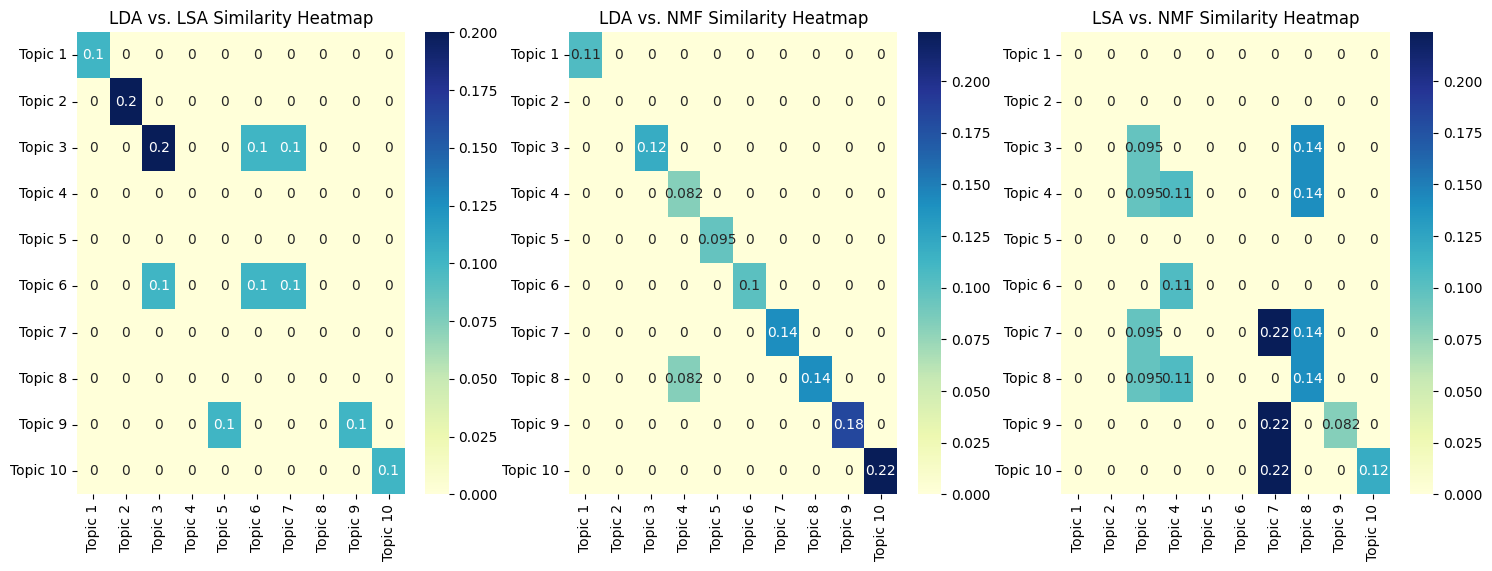

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt

topics = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5','Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']

# Create similarity matrices for each combination of topics
similarity_matrix_lda_lsa = np.zeros((len(lda_topic_words), len(lsa_topic_words)))
similarity_matrix_lda_nmf = np.zeros((len(lda_topic_words), len(nmf_topic_words)))
similarity_matrix_lsa_nmf = np.zeros((len(lsa_topic_words), len(nmf_topic_words)))

# Convert topic words to binary vectors
# Assuming that all_words is the vocabulary used in your topics
all_words = np.array(filtered_vocabulary)

# Convert topic words to binary vectors
binary_lda_topic_words = np.array([[word in topic for word in all_words] for topic in lda_topic_words])
binary_lsa_topic_words = np.array([[word in topic for word in all_words] for topic in lsa_topic_words])
binary_nmf_topic_words = np.array([[word in topic for word in all_words] for topic in nmf_topic_words])


# Calculate cosine similarity between binary vectors
similarity_matrix_lda_lsa = cosine_similarity(binary_lda_topic_words, binary_lsa_topic_words)
similarity_matrix_lda_nmf = cosine_similarity(binary_lda_topic_words, binary_nmf_topic_words)
similarity_matrix_lsa_nmf = cosine_similarity(binary_lsa_topic_words, binary_nmf_topic_words)

# Use the Hungarian algorithm to find the optimal assignment for each combination
row_ind_lda_lsa, col_ind_lda_lsa = linear_sum_assignment(-similarity_matrix_lda_lsa)
row_ind_lda_nmf, col_ind_lda_nmf = linear_sum_assignment(-similarity_matrix_lda_nmf)
row_ind_lsa_nmf, col_ind_lsa_nmf = linear_sum_assignment(-similarity_matrix_lsa_nmf)

# Reorder the similarity matrices based on the optimal assignments
similarity_matrix_lda_lsa_aligned = similarity_matrix_lda_lsa[row_ind_lda_lsa, :][:, col_ind_lda_lsa]
similarity_matrix_lda_nmf_aligned = similarity_matrix_lda_nmf[row_ind_lda_nmf, :][:, col_ind_lda_nmf]
similarity_matrix_lsa_nmf_aligned = similarity_matrix_lsa_nmf[row_ind_lsa_nmf, :][:, col_ind_lsa_nmf]

similarity_matrix_lda_lsa_aligned = similarity_matrix_lda_lsa_aligned[:10, :10]
similarity_matrix_lda_nmf_aligned = similarity_matrix_lda_nmf_aligned[:10, :10]
similarity_matrix_lsa_nmf_aligned = similarity_matrix_lsa_nmf_aligned[:10, :10]
# Plotting the heatmaps for each combination
fig, axes = plt.subplots(1, 3, figsize=(18, 6))



# LDA vs. LSA
sns.heatmap(similarity_matrix_lda_lsa_aligned, annot=True, xticklabels=topics, yticklabels=topics, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('LDA vs. LSA Similarity Heatmap')

# LDA vs. NMF
sns.heatmap(similarity_matrix_lda_nmf_aligned, annot=True, xticklabels=topics, yticklabels=topics, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('LDA vs. NMF Similarity Heatmap')

# LSA vs. NMF
sns.heatmap(similarity_matrix_lsa_nmf_aligned, annot=True, xticklabels=topics, yticklabels=topics, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('LSA vs. NMF Similarity Heatmap')

plt.show()


We have done a lot of Analysis above but the most important one is t-SNE visualisation. As seen above the clusters are too sparse this doesnt indicate a good topical modelling.
The reasons for this can be the following:
1. Inadequate No of Topics
2. Ineffective Topical Modelling Algorithm
3. Small Training Set
4. No Preprocessed Clustering

but as we you can see in our widget you can change the No of Topics and Training Set size. We will use these two as control and compare LDA and LSA by looking at theit t-SNE visualistions and finding their best performance while comparing it with each other. Furthermore we will eliminate the reasoning that lack of preprocessed clustering is causing the poor performance by experimenting with it later on and comparing LDA & LSA again in Experiment 4. Finally we will create a metric on the basis of which we can make fine judgement of which topical modelling algorithm is better

### Top2Vec? and Event Detection?
Too Computationally expensive.



selecting 5 as the optimal value

In [ ]:
num_topics_lda_before = 2
lda_model_before = LatentDirichletAllocation(n_components=num_topics_lda_before, random_state=42)
lda_topic_distributions_before = lda_model_before.fit_transform(Vectorized_Headlines[:1000])

for cluster_id in range(optimal_k):
    cluster_indices = np.where(kmeans_before_lda_labels == cluster_id)[0]
    cluster_X = Vectorized_Headlines[cluster_indices]

    lda_model_cluster = LatentDirichletAllocation(n_components=num_topics_lda_before, random_state=42)
    lda_topic_distributions_cluster = lda_model_cluster.fit_transform(cluster_X)

    print(f"Cluster {cluster_id + 1} - Topics:")
    # for topic_idx, topic in enumerate(lda_model_cluster.components_):
    #     top_word_indices = np.argsort(topic)[::-1][:5]
    #     top_words = [filtered_vocabulary[index] for index in top_word_indices]
    #     # lda_topic_words.append(top_words)
    #     print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
    for topic_id in range(num_topics_lda_before):
        top_words_idx = lda_model_cluster.components_[topic_id].argsort()[::-1][:5]

        print(f"top_words_idx: {top_words_idx}")
        print(f"filtered_vocabulary length: {len(filtered_vocabulary)}")

        if max(top_words_idx) >= len(filtered_vocabulary):
            print(f"Error: Index out of range. Max index: {max(top_words_idx)}, Vocabulary length: {len(filtered_vocabulary)}")
            continue

        top_words = [filtered_vocabulary[i] for i in top_words_idx]
        print(f"Topic {topic_id + 1}: {', '.join(top_words)}")

    print()



Cluster 1 - Topics:
top_words_idx: [99095 97142 48858 35894 21197]
filtered_vocabulary length: 97719
Error: Index out of range. Max index: 99095, Vocabulary length: 97719
top_words_idx: [99095 35894 96629 21197 97142]
filtered_vocabulary length: 97719
Error: Index out of range. Max index: 99095, Vocabulary length: 97719

Cluster 2 - Topics:
top_words_idx: [54907 28186  8134 36139 52317]
filtered_vocabulary length: 97719
Topic 1: meghans, equality, bergmann, greenest, maine
top_words_idx: [86774 47462 38959 69854 52317]
filtered_vocabulary length: 97719
Topic 2: termi, kokoda, hemiplegia, quickened, maine

Cluster 3 - Topics:
top_words_idx: [24042 65859 23946 20745 26377]
filtered_vocabulary length: 97719
Topic 1: disarm, physiotherapy, diprotodons, cultivates, ear
top_words_idx: [76807 73332 30257 48858 72784]
filtered_vocabulary length: 97719
Topic 2: schillabeer, reverends, federici, larium, rescind

Cluster 4 - Topics:
top_words_idx: [58394 89306 19554 24042 60726]
filtered_vocabula

### Results Pre-Processing Model

###   3. Experimenting with K-Means and DBSCAN for Post-processing


###   4. Experimenting with LSA & LDA using chosen Postprocessing Algorithm


### Results Pre-Processing Model

#Conclusion
##Conclusion will answer the following questions:
###1. What algorithm better suited clustering (DBSCAN or K-Means)? Why?
###2. What algorithm better suited topical modelling (LDA or LSA)? Why?
###3. What processing model suited better (Post or Pre)? Why?
###4. What were our overall findings regarding the dataset using all our methods? Describe and Visualise where possible.

# Predictor

In [ ]:
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



new_headline = "Israel mistakenly kills three captives; US urges Israel to 'scale down' attacks"


def preprocess(headline):

    headline = headline.lower().strip()


    tokens = word_tokenize(headline)



    tokens = [token for token in tokens if token not in stop_words_custom]


    pos_tags = pos_tag(tokens)

    filtered_tokens = [word for word, pos in pos_tags if pos.startswith('N') or pos.startswith('V')]


    preprocessed_headline = ' '.join(filtered_tokens)

    return preprocessed_headline








vectorizer = CountVectorizer(vocabulary=filtered_vocabulary)


new_headline_dtm = vectorizer.transform([new_headline])


common_features = np.intersect1d(filtered_vocabulary, vectorizer.get_feature_names_out())


new_headline_dtm = new_headline_dtm[:, np.searchsorted(vectorizer.get_feature_names_out(), common_features)]





lda_topic_distribution = lda_model.transform(new_headline_dtm)


dominant_topic = np.argmax(lda_topic_distribution) + 1

print(f"The dominant topic for the new headline is Topic {dominant_topic}")


top_words = lda_topic_words[dominant_topic - 1]
print(f"Top words for Topic {dominant_topic}: {', '.join(top_words)}")


The dominant topic for the new headline is Topic 24
Top words for Topic 24: tas, rate, israel, remote, music, gaza, strikes, turn, resigns, month
